In [1]:
import osmnx as ox
import pandas as pd
import matplotlib.pyplot as plt
import os

#to save computing capacity, a 1km radius area of the city center will be processed.
area=ox.geocode_to_gdf("Seattle, Washington, USA")
area_poly = area.geometry.iloc[0].centroid.buffer(0.01)
footprints= ox.features_from_polygon(area_poly, tags={"building": True})
#first foorprint extraction from OSM

<Axes: >

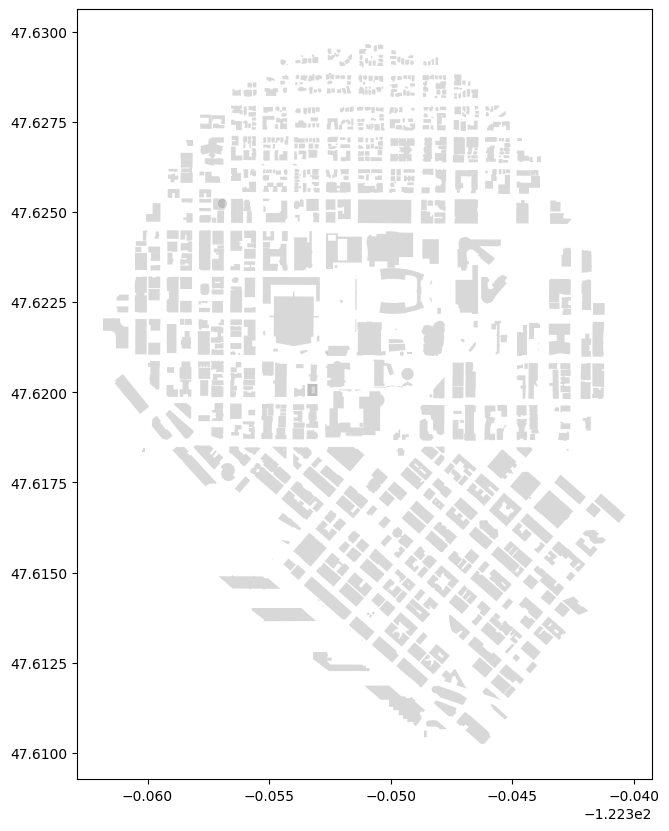

In [2]:
f, ax=plt.subplots(1, 1, figsize=(10, 10))
footprints.plot(ax=ax, color="grey", alpha=0.3, linewidth=0.5)
#plotting for safety

In [3]:
import rasterio

#the area of choice is covered by two different raster files. this time i decided not to merge, since its only 2 files
path_dsm = r"C:\Users\Icy\Documents\CEU\Geospatial\Trial\datasetsB\king_county_west_2021\dsm\king_county_west_2021_dsm_111.tif"
path_dtm = r"C:\Users\Icy\Documents\CEU\Geospatial\Trial\datasetsB\king_county_west_2021\dtm\king_county_west_2021_dtm_111.tif"

with rasterio.open(path_dsm) as dsm_src:
    dsm = dsm_src.read(1)
    dsm_meta = dsm_src.meta

with rasterio.open(path_dtm) as dtm_src:
    dtm = dtm_src.read(1)

#height calculations 
ndsm = dsm - dtm

In [4]:
with rasterio.open(path_dsm) as src:
    raster_crs = src.crs

footprints = footprints.set_geometry("geometry").to_crs(raster_crs)

In [6]:
import numpy as np 

ndsm_clean = np.where((ndsm > 0) & (ndsm < 500), ndsm, -9999) 
#filtering unreasonable values

ndsm_meta = dsm_meta.copy()
ndsm_meta.update(dtype="float32", nodata=-9999)

with rasterio.open("ndsm_temp.tif", "w", **ndsm_meta) as dst:
    dst.write(ndsm_clean.astype("float32"), 1)

from rasterstats import zonal_stats

stats = zonal_stats(footprints, "ndsm_temp.tif", stats=["mean"], nodata=-9999)
footprints["estimated_height"] = [s["mean"] if s else None for s in stats]

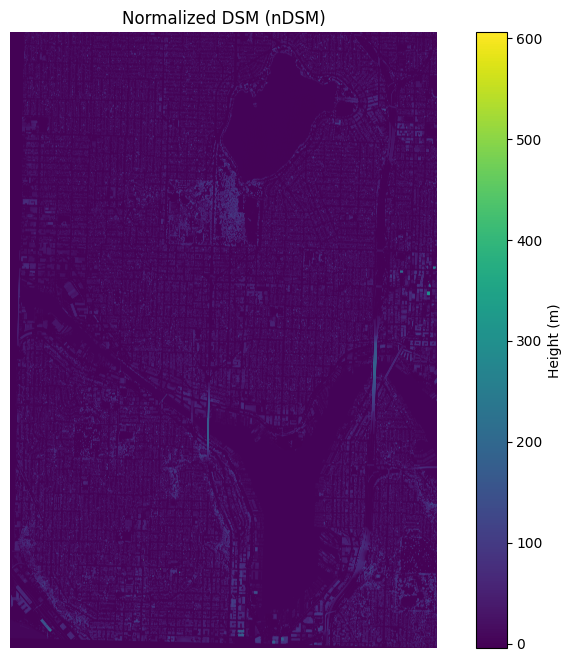

In [7]:
import matplotlib.pyplot as plt

#plot for checking
plt.figure(figsize=(10, 8))
plt.imshow(np.where(ndsm == -9999, np.nan, ndsm), cmap="viridis")
plt.colorbar(label="Height (m)")
plt.title("Normalized DSM (nDSM)")
plt.axis("off")
plt.show()
#luckily those flight streaks do not fall into our area of interest

<Axes: >

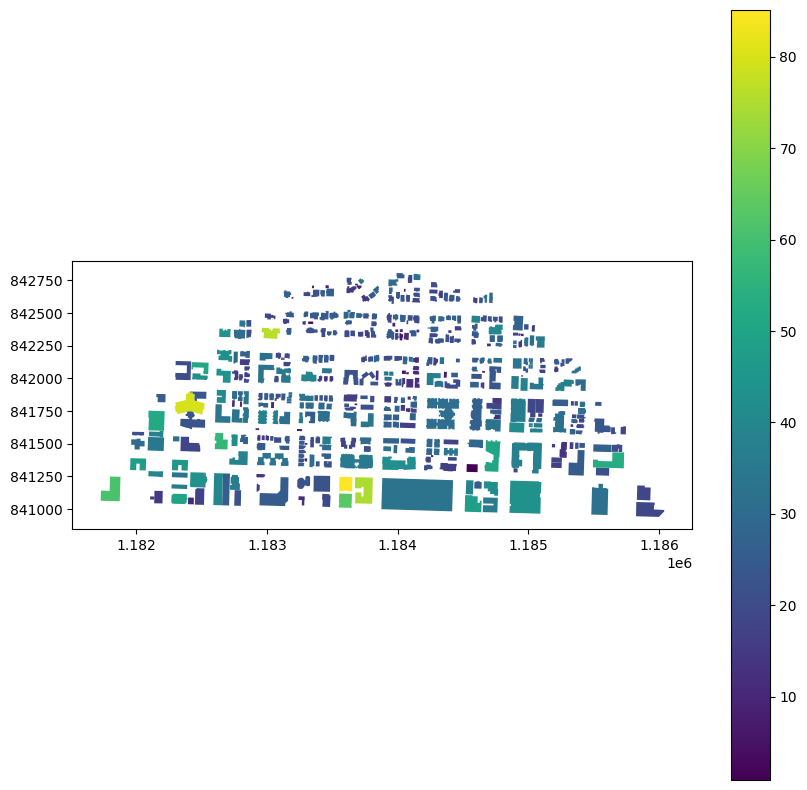

In [8]:
footprints.plot(column="estimated_height", cmap="viridis", legend=True, figsize=(10,10))
#good, first half is OK

In [9]:
#repeat process for the second half of the desired area
path_dsm2= r"C:\Users\Icy\Documents\CEU\Geospatial\Trial\datasetsB\king_county_west_2021\dsm\king_county_west_2021_dsm_89.tif"
path_dtm2= r"C:\Users\Icy\Documents\CEU\Geospatial\Trial\datasetsB\king_county_west_2021\dtm\king_county_west_2021_dtm_89.tif"

with rasterio.open(path_dsm2) as dsm2_src:
    dsm2=dsm2_src.read(1)
    dsm2_meta = dsm2_src.meta

with rasterio.open(path_dtm2) as dtm2_src:
    dtm2= dtm2_src.read(1)
    
ndsm2= dsm2 - dtm2

with rasterio.open(path_dsm2) as src2:
    raster_crs2= src2.crs

footprints2= ox.features_from_polygon(area_poly, tags={"building": True})
footprints2= footprints2.set_geometry("geometry").to_crs(raster_crs2)

ndsm_clean2= np.where((ndsm2 > 0) & (ndsm2 < 1500), ndsm2, -9999)

ndsm2_meta = dsm2_meta.copy()
ndsm2_meta.update(dtype="float32", nodata=-9999)

with rasterio.open("ndsm2_temp.tif", "w", **ndsm2_meta) as dst2:
    dst2.write(ndsm_clean2.astype("float32"), 1)

stats = zonal_stats(footprints2, "ndsm2_temp.tif", stats=["mean"], nodata=-9999)
footprints2["estimated_height"] = [s["mean"] if s else None for s in stats]

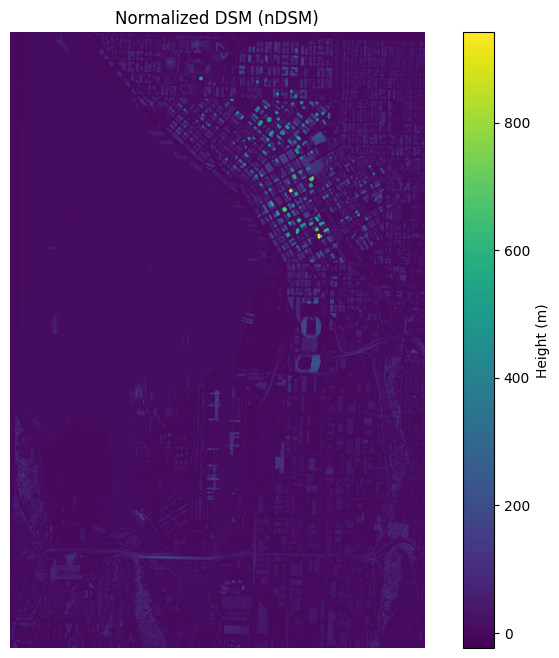

In [10]:
plt.figure(figsize=(10, 8))
plt.imshow(np.where(ndsm2 == -9999, np.nan, ndsm2), cmap="viridis")
plt.colorbar(label="Height (m)")
plt.title("Normalized DSM (nDSM)")
plt.axis("off")
plt.show()

<Axes: >

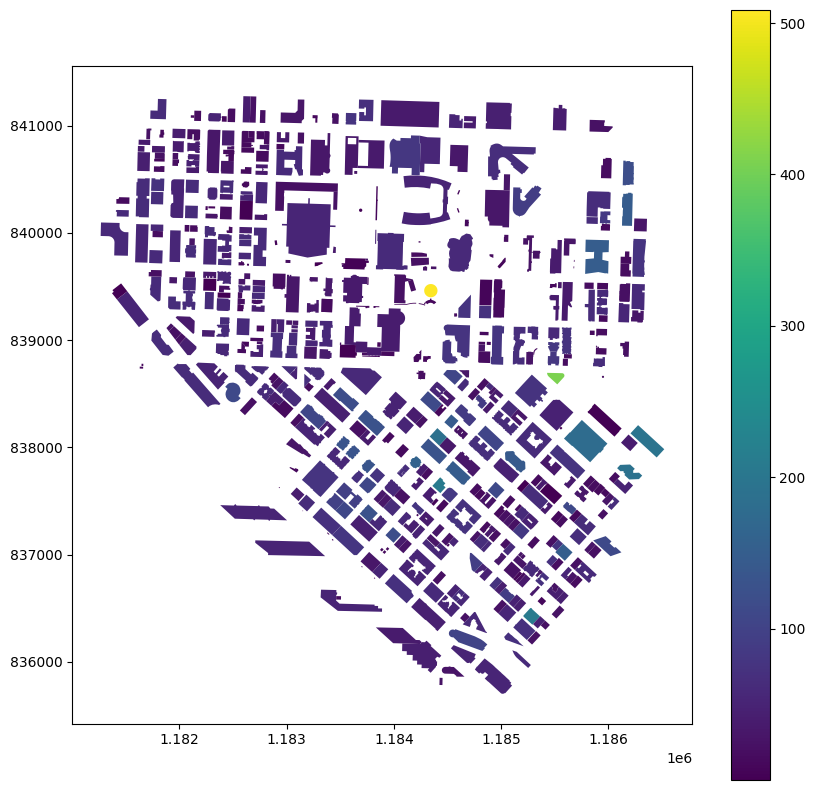

In [11]:
footprints2.plot(column="estimated_height", cmap="viridis", legend=True, figsize=(10,10))
#looks ok. middle yellow structure is likely the space needle

kept: 971
dropped: 957


<Axes: >

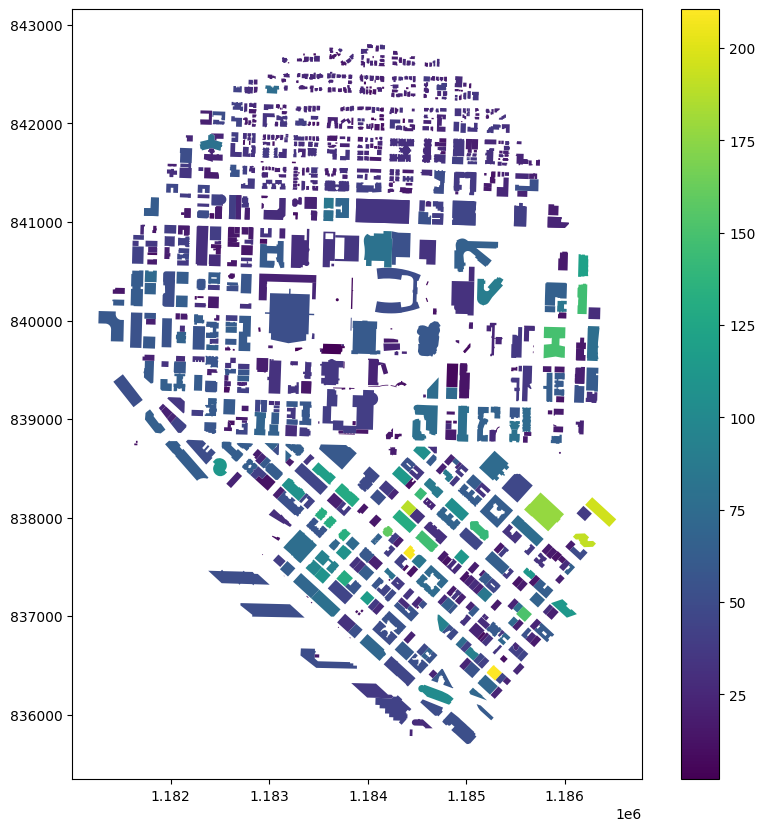

In [12]:
#merge for final data output
footprints_all= pd.concat([footprints, footprints2], ignore_index=True)

#inspecting where data is unresonable, excluding print not to litter notebook
null_heights = footprints_all[footprints_all["estimated_height"].isnull()]
sus_heights = footprints_all[
    (footprints_all["estimated_height"] < 2) |
    (footprints_all["estimated_height"] > 150)
]

#cleaning of missing estimates and invalid estimates 
footprints_clean= footprints_all[footprints_all["estimated_height"].notnull()]
footprints_clean= footprints_all[(footprints_all["estimated_height"] > 2) & 
                                          (footprints_all["estimated_height"] < 300)]

print(f"kept: {len(footprints_clean)}")
print(f"dropped: {len(footprints_all) - len(footprints_clean)}")

footprints_clean.plot(column="estimated_height", cmap="viridis", legend=True, figsize=(10,10))
#looks OK

In [13]:
#a rough estimate of floorspace
footprints_clean["estimated_floors"] = (footprints_clean["estimated_height"] / 3).round()
footprints_clean["floor_area"] = footprints_clean.geometry.area * footprints_clean["estimated_floors"]

footprints_clean.to_file("seattle_building_heights_clean.geojson", driver="GeoJSON")

C:\Users\Icy\anaconda3\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\Icy\anaconda3\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


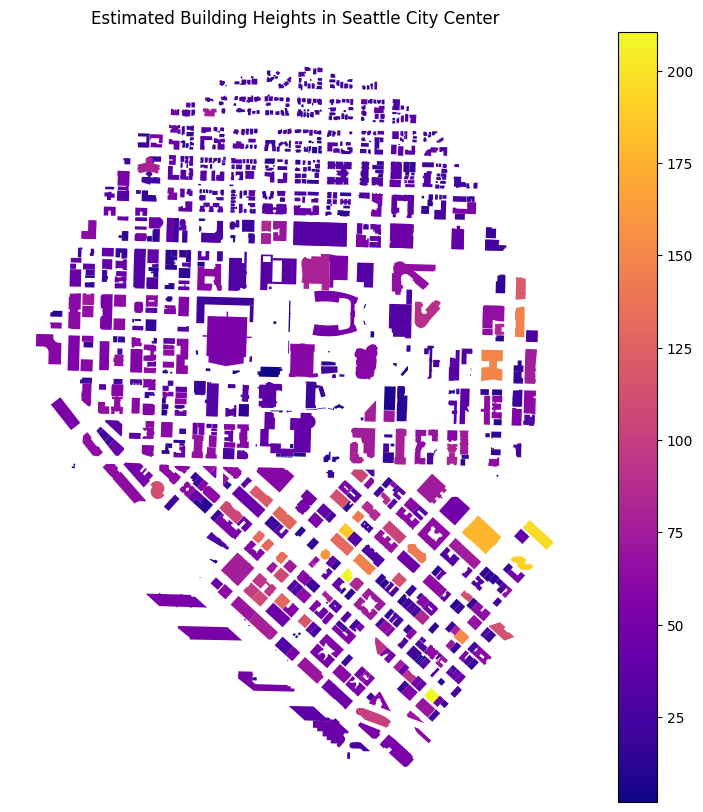

In [14]:
fig, ax = plt.subplots(figsize=(10, 10))
footprints_clean.plot(ax=ax, column="estimated_height", cmap="plasma", legend=True)
plt.axis("off")
plt.title("Estimated Building Heights in Seattle City Center")
plt.savefig("preview_map.png", dpi=300, bbox_inches="tight")

In [15]:
gdf=gpd.read_file("seattle_building_heights_clean.geojson")

In [27]:
#reprojecting for viewing purposes
gdf= gdf.set_crs(epsg=2285, allow_override=True)  
gdf_latlon =gdf.to_crs(epsg=4326)
gdf_latlon.to_file("seattle_building_heights_clean_latlon.geojson", driver="GeoJSON")